# Sliderule data I/O

This notebook will highlight analyzing various coincident elevation measurements. We will find regions with and use sliderule to retrieve ICESat-2 and GEDI point elevation measurements.

```{note}
Keep in mind, these measurements are from different sensor types, close in time, but not at exactly the same time. All measurements also have uncertainties, so we do not expect perfect agreement.
```

In [1]:
import coincident
import matplotlib.pyplot as plt

# For testing
# sliderule.init(url='slideruleearth.io', verbose=True)

%matplotlib inline

## Identify a primary dataset

Start by loading a full resolution polygon of a 3DEP LiDAR workunit which has a known start_datetime and end_datatime:

In [2]:
workunit = "CO_WestCentral_2019"
df_wesm = coincident.search.wesm.read_wesm_csv()
gf_lidar = coincident.search.wesm.load_by_fid(
    df_wesm[df_wesm.workunit == workunit].index
)
gf_lidar

,workunit,workunit_id,project,project_id,start_datetime,end_datetime,ql,spec,p_method,dem_gsd_meters,...,seamless_category,seamless_reason,lpc_link,sourcedem_link,metadata_link,geometry,collection,datetime,dayofyear,duration
0,CO_WestCentral_2019,175984,CO_WestCentral_2019_A19,175987,2019-08-21,2019-09-19,QL 2,USGS Lidar Base Specification 1.3,linear-mode lidar,1.0,...,Meets,Meets 3DEP seamless DEM requirements,https://rockyweb.usgs.gov/vdelivery/Datasets/S...,http://prd-tnm.s3.amazonaws.com/index.html?pre...,http://prd-tnm.s3.amazonaws.com/index.html?pre...,"MULTIPOLYGON (((-106.13571 38.4146, -106.1702 ...",3DEP,2019-09-04 12:00:00,247,29


## Search secondary datasets

Provide a list that will be searched in order. The list contains tuples of dataset aliases and the temporal pad in days to search before the primary dataset start and end dates

In [3]:
# For more control, modify the dataset object being searched
# For example, search for ATL06 instead of default ATL03
is2 = coincident.datasets.nasa.ICESat2()
is2.collections = ["ATL06_006"]
print(is2)

ICESat2(alias='icesat-2', has_stac_api=True, collections=['ATL06_006'], search='https://cmr.earthdata.nasa.gov/stac/NSIDC_ECS', start='2018-10-13', end=None, type='altimeter', provider='nasa', stac_kwargs={'limit': 1000})


In [ ]:
secondary_datasets = [
    ("gedi", 40),  # +/- 40 days from lidar
    (is2, 60),  # +/- 60 days from lidar
]

gf_gedi, gf_is2 = coincident.search.cascading_search(
    gf_lidar,
    secondary_datasets,
    min_overlap_area=30,  # km^2
)

## Get ICESat-2 ATL06 Data

We've identified 7 granules of icesat-2 data to examine, but there is no need to work with the entire granule, which spans a huge geographic extent. Instead we'll retrive a subset of elevation values in the area of interest for each granule.

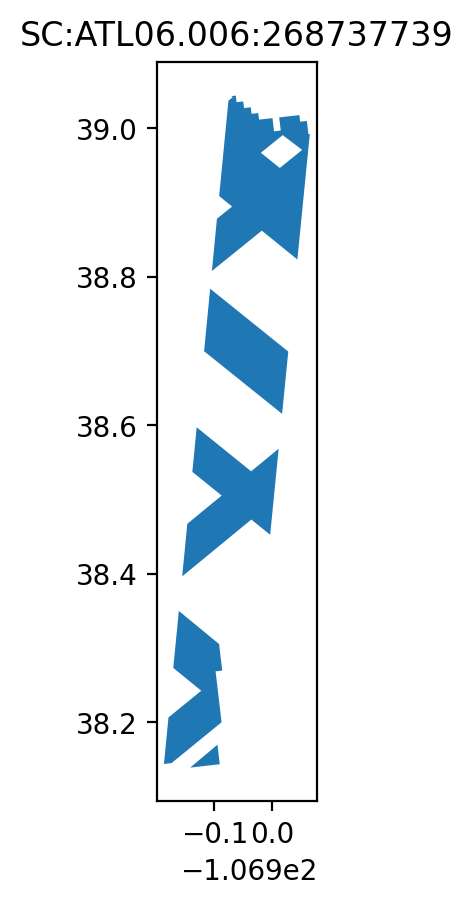

In [5]:
# Hone in on single granule as a pandas series
i = 0
granule_gdf = gf_is2.iloc[[i]]
granule = gf_is2.iloc[i]
granule_gdf.plot()  # needs to be a geodataframe
plt.title(granule.id);
# The icesat-2 track trends N-S, and is crossed by multiple GEDI tracks, resulting in the crosshatched appearance

In [6]:
data_is2 = coincident.io.sliderule.subset_atl06(granule_gdf)

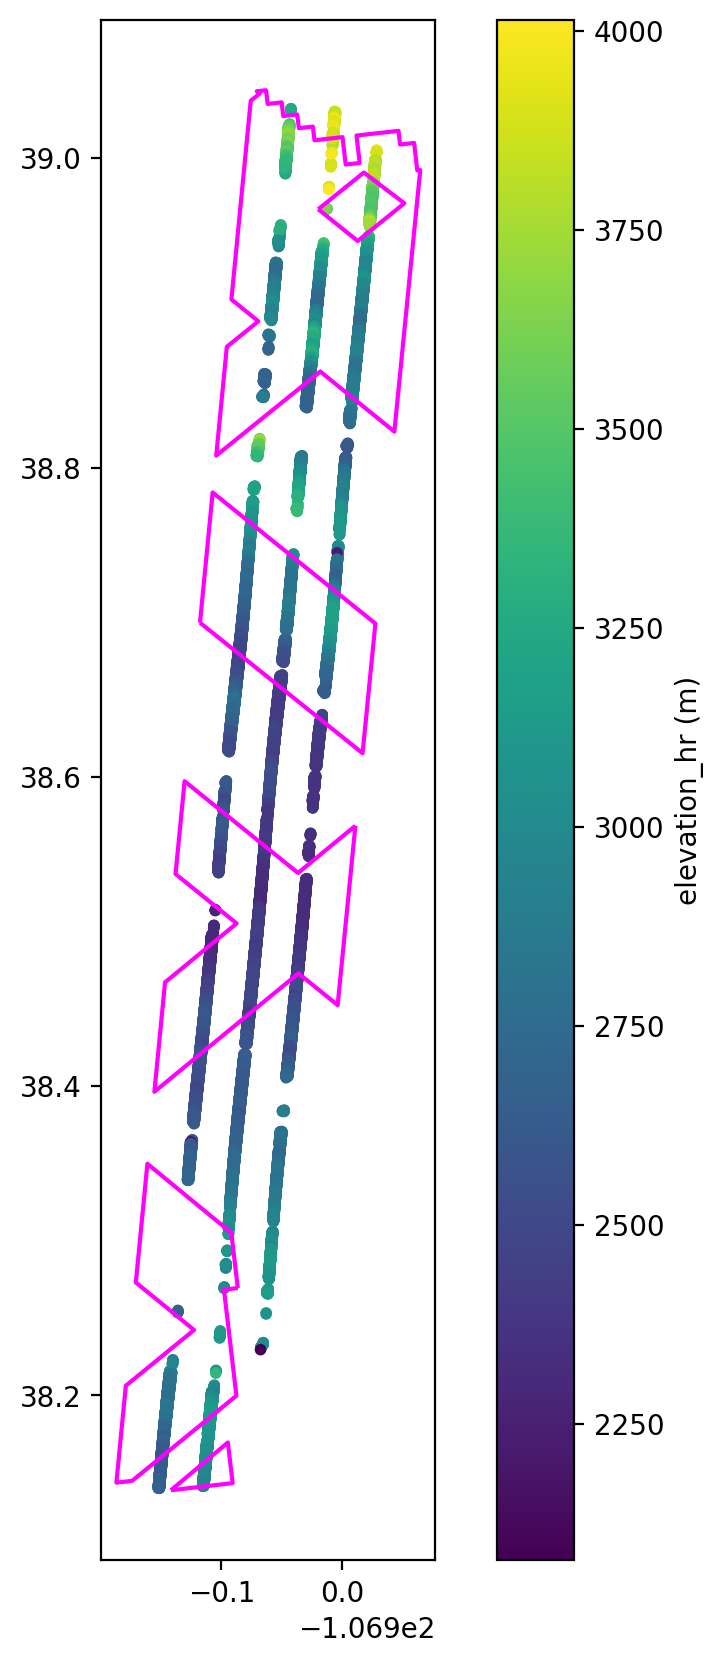

In [7]:
# Plot this data and overlay footprint
fig, ax = plt.subplots(figsize=(8, 10))
plt.scatter(
    x=data_is2.geometry.x,
    y=data_is2.geometry.y,
    c=data_is2.h_li,
    s=10,
)
granule_gdf.dissolve().boundary.plot(ax=ax, color="magenta")
cb = plt.colorbar()
cb.set_label("elevation_hr (m)")

```{note}
`sliderule` gets data from the envelope of multipolygon, not only data within intersecting GEDI tracks. Along-track gaps are where there is missing data.
```

In [8]:
# Here, we specify aoi=granule_gdf to only return GEDI data
# in our icesat-2 track of interest
data_gedi = coincident.io.sliderule.subset_gedi02a(
    gf_gedi,
    aoi=granule_gdf,
)

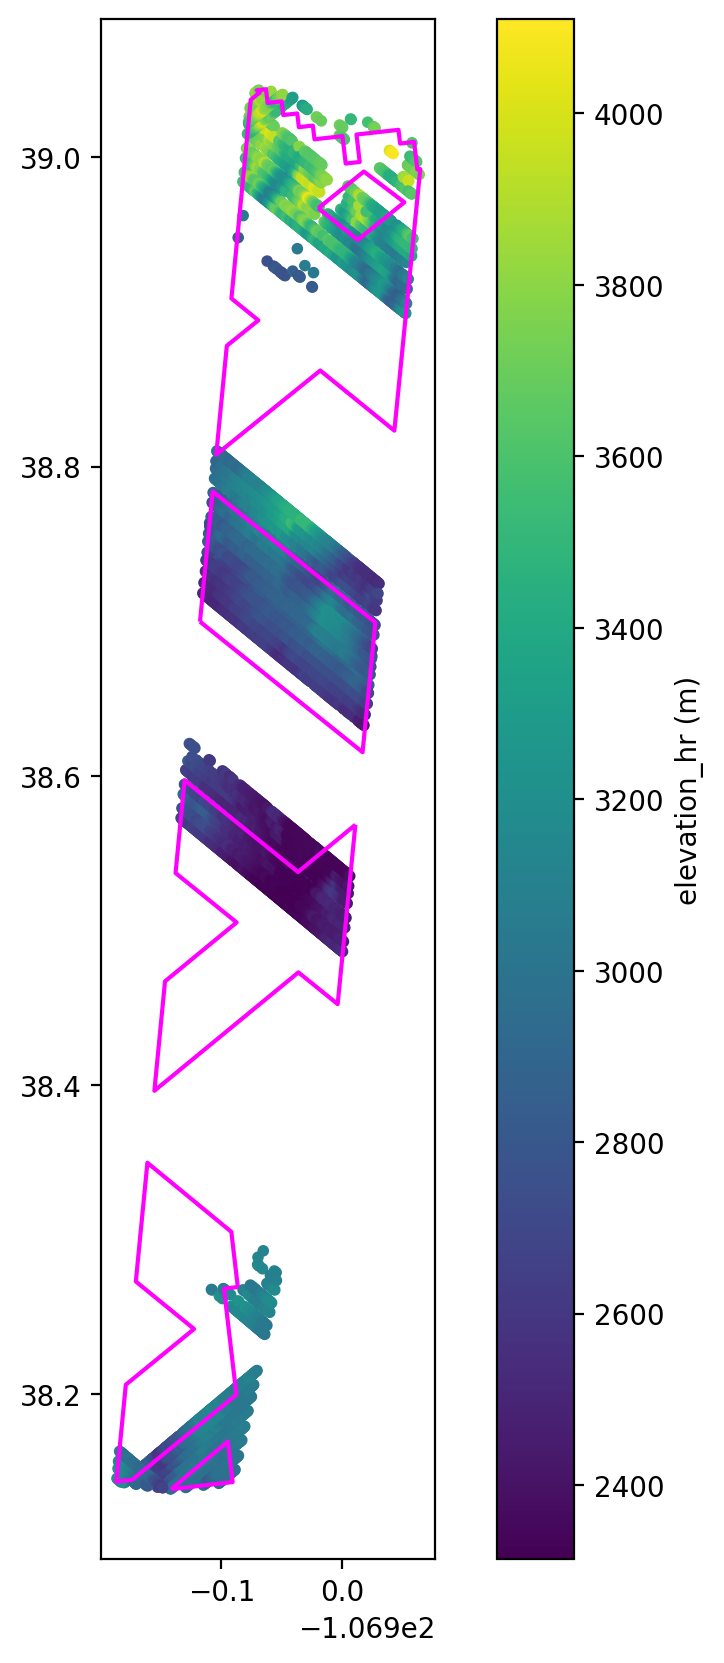

In [9]:
# Plot this data and overlay footprint
fig, ax = plt.subplots(figsize=(8, 10))
plt.scatter(
    x=data_gedi.geometry.x,
    y=data_gedi.geometry.y,
    c=data_gedi.elevation_hr,
    s=10,
)
granule_gdf.dissolve().boundary.plot(ax=ax, color="magenta")
cb = plt.colorbar()
cb.set_label("elevation_hr (m)")

**NOTE** Like ICESat-2, it's possible to have points falling outside the estimated footprints

## Spatial join: nearest points

NOTE: we will not worry about the difference in time of acquisition between adjacent points for now

In [10]:
%%time

utm_crs = granule_gdf.estimate_utm_crs()
subset_is2 = data_is2.to_crs(utm_crs)
subset_gedi = data_gedi.to_crs(utm_crs)

CPU times: user 126 ms, sys: 8 ms, total: 134 ms
Wall time: 139 ms


In [11]:
%%time

# find nearest IS2 point to each GEDI
result = subset_gedi.sjoin_nearest(
    subset_is2,
    how="left",
    max_distance=100,  # at most 100m apart
    distance_col="distances",
)
# index is GEDI subset (with _left added), with _right apprended to is2 columns + Distances in meters
result = result[result["distances"].notna()]
len(result)

CPU times: user 8.72 ms, sys: 1.21 ms, total: 9.93 ms
Wall time: 9.18 ms


469

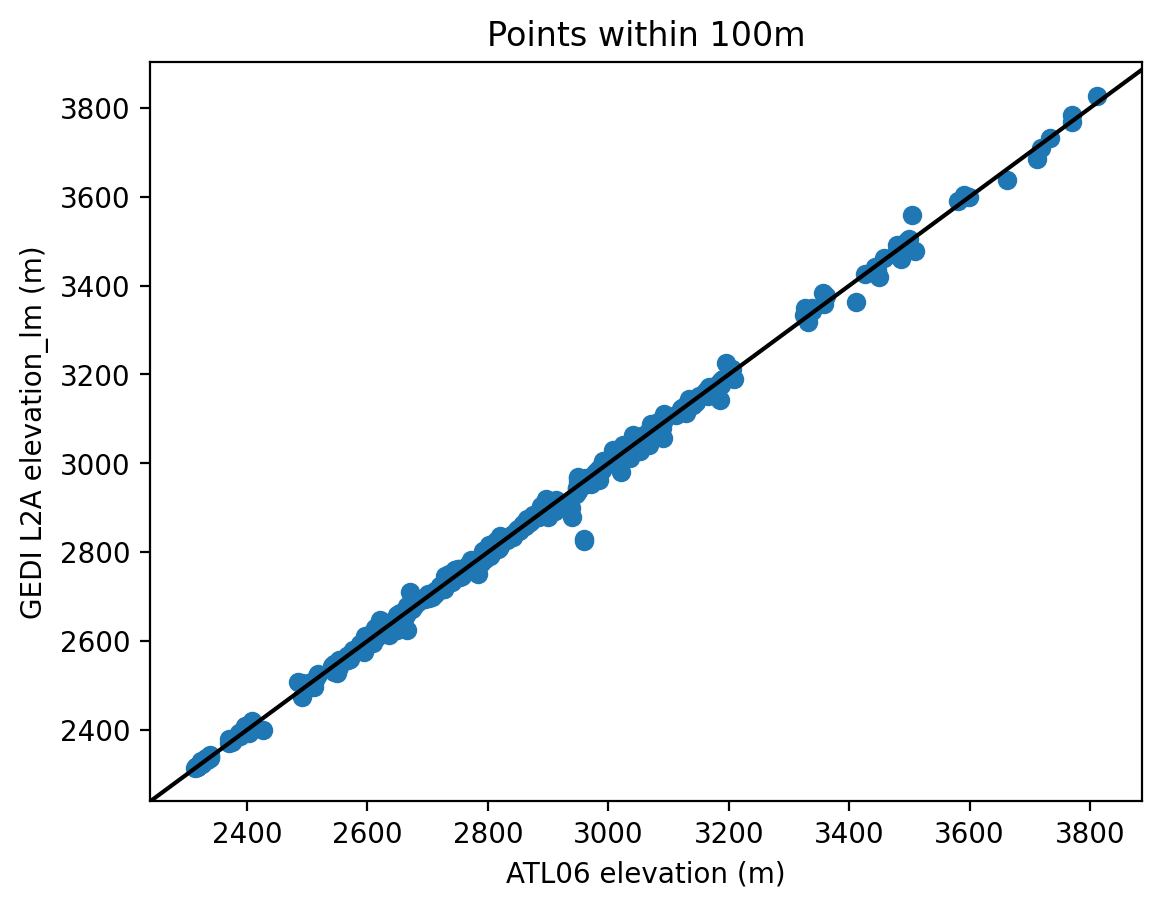

In [12]:
fig, ax = plt.subplots()
plt.scatter(result.h_li, result.elevation_lm)
ax.axline((0, 0), slope=1, color="k", transform=ax.transAxes)
plt.xlabel("ATL06 elevation (m)")
plt.ylabel("GEDI L2A elevation_lm (m)")
plt.title("Points within 100m");